In [1]:
### IMPORTING LIBRARIES

In [1]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose ,Concatenate, Add
from keras.models import Model
from keras import optimizers
from keras import backend as K
from tensorflow import keras
from keras.callbacks import TensorBoard
import tensorflow as tf
from SSIM_PIL import compare_ssim as ssim
from PIL import Image
import os, glob
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity
import argparse
import imutils
import cv2
import numpy as np
from scipy import signal

2023-08-17 11:04:30.980189: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
### AUTOENCODER ARCHITECTURE

In [2]:
input_img = Input(shape=(128, 128, 1))  
# Encode-----------------------------------------------------------
x = Conv2D(32, (4, 4), strides=2 , activation='relu', padding='same')(input_img)
x = Conv2D(32, (4, 4), strides=2, activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
x = Conv2D(64, (4, 4), strides=2, activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x = Conv2D(128, (4, 4), strides=2, activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
encoded = Conv2D(100, (8, 8), strides=1, padding='same')(x)
# Decode---------------------------------------------------------------------
x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(encoded)
x = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (4, 4), strides=2, activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (4, 4), strides=2, activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (4, 4), strides=2, activation='relu', padding='same')(x)
x = UpSampling2D((4, 4))(x)
x = Conv2D(32, (4, 4), strides=2, activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (8, 8), activation='sigmoid', padding='same')(x)

2023-08-17 11:04:35.737902: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [116]:
# input_img = Input(shape=(256, 256, 1))  
# # Encode-----------------------------------------------------------
# x = Conv2D(32, (4, 4), strides=2 , activation='relu', padding='same')(input_img)
# x = Conv2D(32, (4, 4), strides=2, activation='relu', padding='same')(x)
# x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
# x = Conv2D(64, (4, 4), strides=2, activation='relu', padding='same')(x)
# x = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
# x = Conv2D(128, (4, 4), strides=2, activation='relu', padding='same')(x)
# x = Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
# x = Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
# encoded = Conv2D(256, (8, 8), strides=1, padding='same')(x)
# # Decode---------------------------------------------------------------------
# x = Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(encoded)
# x = Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
# x = Conv2DTranspose(256, (4,4), padding='same', strides=(2, 2))(x)
# x = Conv2D(128, (4, 4), strides=2, activation='relu', padding='same')(x)
# x = Conv2DTranspose(128, (4,4), padding='same', strides=(2, 2))(x)
# x = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
# x = Conv2DTranspose(64, (4,4), padding='same', strides=(2, 2))(x)
# x = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
# x = Conv2DTranspose(64, (4,4), padding='same', strides=(2, 2))(x)
# x = Conv2D(64, (4, 4), strides=2, activation='relu', padding='same')(x)
# x = Conv2DTranspose(32, (4,4), padding='same', strides=(2, 2))(x)
# x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
# x = Conv2DTranspose(32, (4,4), padding='same', strides=(2, 2))(x)
# x = Conv2D(32, (4, 4), strides=2, activation='relu', padding='same')(x)
# x = Conv2DTranspose(16, (4,4), padding='same', strides=(2, 2))(x)
# x = Conv2D(32, (4, 4), strides=2, activation='relu', padding='same')(x)
# x = Conv2DTranspose(16, (4,4), padding='same', strides=(2, 2))(x)
# decoded = Conv2D(1, (8, 8), activation='sigmoid', padding='same')(x)

In [72]:
# # Without same Padding

# input_img = Input(shape=(256, 256, 1))  
# # Encode-----------------------------------------------------------
# x = Conv2D(32, (4, 4), strides=2 , activation='relu', padding='valid')(input_img)
# #x = Conv2D(32, (4, 4), strides=2, activation='relu', padding='valid')(x)
# x = Conv2D(32, (4, 4), strides=1, activation='relu', padding='valid')(x)
# x = Conv2D(64, (4, 4), strides=2, activation='relu', padding='valid')(x)
# x = Conv2D(64, (4, 4), strides=1, activation='relu', padding='valid')(x)
# x = Conv2D(128, (4, 4), strides=2, activation='relu', padding='valid')(x)
# #x = Conv2D(128, (3, 3), strides=1, activation='relu', padding='valid')(x)
# x = Conv2D(256, (4, 4), strides=2, activation='relu', padding='valid')(x)
# x = Conv2D(256, (3, 3), strides=1, padding='valid')(x)
# encoded = Conv2D(512, (4,4), strides=2, padding='valid')(x)
# # Decode---------------------------------------------------------------------
# x = Conv2D(256, (4, 4), strides=1, activation='relu', padding='same')(encoded)
# #x = Conv2D(256, (3, 3), strides=1, activation='relu', padding='valid')(x)
# x = Conv2DTranspose((2, 2))(x)
# x = Conv2D(128, (4, 4), strides=1, activation='relu', padding='same')(x)
# x = Conv2DTranspose((2, 2))(x)
# x = Conv2D(64, (4, 4), strides=1, activation='relu', padding='same')(x)
# x = Conv2DTranspose((2, 2))(x)
# x = Conv2D(64, (4, 4), strides=1, activation='relu', padding='same')(x)
# x = Conv2DTranspose((2, 2))(x)
# x = Conv2D(32, (4, 4), strides=1, activation='relu', padding='same')(x)
# x = Conv2DTranspose((2, 2))(x)
# x = Conv2D(32, (4, 4), strides=1, activation='relu', padding='same')(x)
# x = Conv2DTranspose((2, 2))(x)
# #x = Conv2D(32, (4, 4), strides=1, activation='relu', padding='same')(x)
# #x = UpSampling2D((2, 2))(x)
# decoded = Conv2D(1, (8, 8), activation='sigmoid', padding='same')(x)

In [55]:
# input_img = Input(shape=(256, 256, 1))  
# # Encode-----------------------------------------------------------
# x1 = Conv2D(16, (3, 3), strides=1 , activation='relu', padding='same')(input_img)
# x1 = Conv2D(16, (3, 3), strides=1 , activation='relu', padding='same')(x1)
# x2 = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None)(x1)
# x2 = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x2)
# x2 = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x2)
# x3 = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None)(x2)
# #x3 = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x2)
# x3 = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x3)
# x3 = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x3)
# x4 = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None)(x3)
# #x5 = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
# x4 = Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x4)
# x4 = Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x4)
# x5 = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None)(x4)
# x5 = Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x5)
# x5 = Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x5)
# encoded= MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None)(x5)
# #x8 = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
# encoded = Conv2D(512, (3, 3), strides=1, padding='same')(encoded)
# encoded = Conv2D(512, (3, 3), strides=1, padding='same')(encoded)
# # Decode---------------------------------------------------------------------
# #x6 = Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(encoded)
# #x6 = Conv2D(512, (3, 3), strides=1, activation='relu', padding='same')(x6)
# #x = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
# x6 = UpSampling2D((2, 2))(encoded)
# x7 = Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x6)
# #x7 = Add()([x7, x5])
# #x7 = Concatenate(axis = -1)([x7, x5])
# x7 = Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x7)
# x7 = UpSampling2D((2, 2))(x7)
# x8 = Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x7)
# #x8 = Add()([x8, x4])
# #x8 = Concatenate(axis = -1)([x8, x4])
# x8 = Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x8)
# x8 = UpSampling2D((2, 2))(x8)
# x9 = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x8)
# #x9 = Add()([x9, x3])
# #x9 = Concatenate(axis = -1)([x9, x3])
# x9 = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x9)
# x9 = UpSampling2D((2, 2))(x9)
# x10 = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x9)
# #x10 = Add()([x10, x2])
# #x10 = Concatenate(axis = -1)([x10, x2])
# x10 = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x10)
# x10 = UpSampling2D((2, 2))(x10)
# x11 = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same')(x10)
# #x11 = Add()([x11, x1])
# #x11 = Concatenate(axis = -1)([x11, x1])
# x11 = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same')(x11)
# #x = UpSampling2D((4, 4))(x)
# #x = Conv2D(32, (4, 4), strides=2, activation='relu', padding='same')(x)
# #x = UpSampling2D((2, 2))(x)
# decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x11)

# #decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoded)

In [56]:
# #ResUnet
# """
# ResUNet architecture in Keras TensorFlow
# """
# from tensorflow.keras.layers import *
# from tensorflow.keras.models import Model

# class ResUnet:
#     def __init__(self, input_size=256):
#         self.input_size = input_size

#     def build_model(self):
#         def conv_block(x, n_filter):
#             x_init = x

#             ## Conv 1
#             x = BatchNormalization()(x)
#             x = Activation("relu")(x)
#             x = Conv2D(n_filter, (1, 1), padding="same")(x)
#             ## Conv 2
#             x = BatchNormalization()(x)
#             x = Activation("relu")(x)
#             x = Conv2D(n_filter, (3, 3), padding="same")(x)
#             ## Conv 3
#             x = BatchNormalization()(x)
#             x = Activation("relu")(x)
#             x = Conv2D(n_filter, (1, 1), padding="same")(x)

#             ## Shortcut
#             s  = Conv2D(n_filter, (1, 1), padding="same")(x_init)
#             s = BatchNormalization()(s)

#             ## Add
#             x = Add()([x, s])
#             return x

#         def resnet_block(x, n_filter, pool=True):
#             x1 = conv_block(x, n_filter)
#             c = x1

#             ## Pooling
#             if pool == True:
#                 x = MaxPooling2D((2, 2), (2, 2))(x)
#                 return c, x
#             else:
#                 return c

#         n_filters = [16, 32, 64, 96, 128]
#         inputs = Input((self.input_size, self.input_size, 1))

#         c0 = inputs
#         ## Encoder
#         c1, p1 = resnet_block(c0, n_filters[0])
#         c2, p2 = resnet_block(p1, n_filters[1])
#         c3, p3 = resnet_block(p2, n_filters[2])
#         c4, p4 = resnet_block(p3, n_filters[3])

#         ## Bridge
#         b1 = resnet_block(p4, n_filters[4], pool=False)
#         b2 = resnet_block(b1, n_filters[4], pool=False)

#         ## Decoder
#         d1 = Conv2DTranspose(n_filters[3], (3, 3), padding="same", strides=(2, 2))(b2)
#         #d1 = UpSampling2D((2, 2))(b2)
#         d1 = Concatenate()([d1, c4])
#         d1 = resnet_block(d1, n_filters[3], pool=False)

#         d2 = Conv2DTranspose(n_filters[3], (3, 3), padding="same", strides=(2, 2))(d1)
#         #d2 = UpSampling2D((2, 2))(d1)
#         d2 = Concatenate()([d2, c3])
#         d2 = resnet_block(d2, n_filters[2], pool=False)

#         d3 = Conv2DTranspose(n_filters[3], (3, 3), padding="same", strides=(2, 2))(d2)
#         #d3 = UpSampling2D((2, 2))(d2)
#         d3 = Concatenate()([d3, c2])
#         d3 = resnet_block(d3, n_filters[1], pool=False)

#         d4 = Conv2DTranspose(n_filters[3], (3, 3), padding="same", strides=(2, 2))(d3)
#         #d4 = UpSampling2D((2, 2))(d3)
#         d4 = Concatenate()([d4, c1])
#         d4 = resnet_block(d4, n_filters[0], pool=False)

#         ## output
#         outputs = Conv2D(1, (1, 1), padding="same")(d4)
#         outputs = BatchNormalization()(outputs)
#         outputs = Activation("sigmoid")(outputs)

#         ## Model
#         model = Model(inputs, outputs)
#         return model

In [57]:
# """
# ResUNet++ architecture in Keras TensorFlow
# """
# import os
# import numpy as np
# import cv2

# import tensorflow as tf
# from tensorflow.keras.layers import *
# from tensorflow.keras.models import Model

# def squeeze_excite_block(inputs, ratio=8):
#     init = inputs
#     channel_axis = -1
#     filters = init.shape[channel_axis]
#     se_shape = (1, 1, filters)

#     se = GlobalAveragePooling2D()(init)
#     se = Reshape(se_shape)(se)
#     se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
#     se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

#     x = Multiply()([init, se])
#     return x

# def stem_block(x, n_filter, strides):
#     x_init = x

#     ## Conv 1
#     x = Conv2D(n_filter, (3, 3), padding="same", strides=strides)(x)
#     x = BatchNormalization()(x)
#     x = Activation("relu")(x)
#     x = Conv2D(n_filter, (3, 3), padding="same")(x)

#     ## Shortcut
#     s  = Conv2D(n_filter, (1, 1), padding="same", strides=strides)(x_init)
#     s = BatchNormalization()(s)

#     ## Add
#     x = Add()([x, s])
#     x = squeeze_excite_block(x)
#     return x


# def resnet_block(x, n_filter, strides=1):
#     x_init = x

#     ## Conv 1
#     x = BatchNormalization()(x)
#     x = Activation("relu")(x)
#     x = Conv2D(n_filter, (3, 3), padding="same", strides=strides)(x)
#     ## Conv 2
#     x = BatchNormalization()(x)
#     x = Activation("relu")(x)
#     x = Conv2D(n_filter, (3, 3), padding="same", strides=1)(x)

#     ## Shortcut
#     s  = Conv2D(n_filter, (1, 1), padding="same", strides=strides)(x_init)
#     s = BatchNormalization()(s)

#     ## Add
#     x = Add()([x, s])
#     x = squeeze_excite_block(x)
#     return x

# def aspp_block(x, num_filters, rate_scale=1):
#     x1 = Conv2D(num_filters, (3, 3), dilation_rate=(6 * rate_scale, 6 * rate_scale), padding="same")(x)
#     x1 = BatchNormalization()(x1)

#     x2 = Conv2D(num_filters, (3, 3), dilation_rate=(12 * rate_scale, 12 * rate_scale), padding="same")(x)
#     x2 = BatchNormalization()(x2)

#     x3 = Conv2D(num_filters, (3, 3), dilation_rate=(18 * rate_scale, 18 * rate_scale), padding="same")(x)
#     x3 = BatchNormalization()(x3)

#     x4 = Conv2D(num_filters, (3, 3), padding="same")(x)
#     x4 = BatchNormalization()(x4)

#     y = Add()([x1, x2, x3, x4])
#     y = Conv2D(num_filters, (1, 1), padding="same")(y)
#     return y

# def attetion_block(g, x):
#     """
#         g: Output of Parallel Encoder block
#         x: Output of Previous Decoder block
#     """

#     filters = x.shape[-1]

#     g_conv = BatchNormalization()(g)
#     g_conv = Activation("relu")(g_conv)
#     g_conv = Conv2D(filters, (3, 3), padding="same")(g_conv)

#     g_pool = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(g_conv)

#     x_conv = BatchNormalization()(x)
#     x_conv = Activation("relu")(x_conv)
#     x_conv = Conv2D(filters, (3, 3), padding="same")(x_conv)

#     gc_sum = Add()([g_pool, x_conv])

#     gc_conv = BatchNormalization()(gc_sum)
#     gc_conv = Activation("relu")(gc_conv)
#     gc_conv = Conv2D(filters, (3, 3), padding="same")(gc_conv)

#     gc_mul = Multiply()([gc_conv, x])
#     return gc_mul

# class ResUnetPlusPlus:
#     def __init__(self, input_size=256):
#         self.input_size = input_size

#     def build_model(self):
#         n_filters = [16, 32, 64, 128, 256]
#         inputs = Input((self.input_size, self.input_size, 1))

#         c0 = inputs
#         c1 = stem_block(c0, n_filters[0], strides=1)

#         ## Encoder
#         c2 = resnet_block(c1, n_filters[1], strides=2)
#         c3 = resnet_block(c2, n_filters[2], strides=2)
#         c4 = resnet_block(c3, n_filters[3], strides=2)

#         ## Bridge
#         b1 = aspp_block(c4, n_filters[4])

#         ## Decoder
#         d1 = attetion_block(c3, b1)
#         d1 = UpSampling2D((2, 2))(d1)
#         d1 = Concatenate()([d1, c3])
#         d1 = resnet_block(d1, n_filters[3])

#         d2 = attetion_block(c2, d1)
#         d2 = UpSampling2D((2, 2))(d2)
#         d2 = Concatenate()([d2, c2])
#         d2 = resnet_block(d2, n_filters[2])

#         d3 = attetion_block(c1, d2)
#         d3 = UpSampling2D((2, 2))(d3)
#         d3 = Concatenate()([d3, c1])
#         d3 = resnet_block(d3, n_filters[1])

#         ## output
#         outputs = aspp_block(d3, n_filters[0])
#         outputs = Conv2D(1, (1, 1), padding="same")(outputs)
#         outputs = Activation("sigmoid")(outputs)

#         ## Model
#         model = Model(inputs, outputs)
#         return model

In [58]:
### SSIM LOSS FUNCTION

In [3]:
#ssim loss function
def ssim_loss(y_true,y_pred):
    return 1-tf.reduce_mean(tf.image.ssim(y_true,y_pred,1.0))

def mse_loss(y_true, y_pred):
    return tf.reduce_mean((y_pred-y_true)**2)

In [10]:
### TRAINING AUTOENCODER MODEL

In [4]:
# MODEL SUMMARY---------------------------------------------------------------------
autoencoder = Model(input_img, decoded)
# enc = ResUnetPlusPlus()
# autoencoder = enc.build_model()
adam = keras.optimizers.legacy.Adam(learning_rate=0.0002, decay=0.00001)
autoencoder.compile(optimizer='adam', loss= ssim_loss)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        544       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        16416     
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        32832     
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 128)         131200

In [5]:

# TRAINING MODEL WITH OUR Own Image Directory---------------------------------------
img_dir = (r"/home/pratyush-g/Documents/Surface Defect Dataset Chmvae/Magnetic-Tile-Defect/Augmented_MT/")
img_files = glob.glob(img_dir + "*.jpg")
# Setting Image Properties
width = 128
height = 128
pixels = width * height * 1 # gray scale 

# Load Image 
x = []

for i, f in enumerate(img_files):
    img = Image.open(f)
#   img = img.convert("RGB")
    img = img.convert("L") # gray scale
    img = img.resize((width,height), 1)
    data = np.asarray(img)
    
    x.append(data)
    if i % 100 == 0:
        print(i, "\n", data)

x = np.array(x)
(x_train, x_test) = train_test_split(x, train_size=0.8, shuffle=False, test_size=0.2, random_state=0)

img_list = (x_train, x_test)
np.save("./obj.npy", img_list)
print("OK", len(x)) 

# change to float32
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 128, 128, 1))  
x_test = np.reshape(x_test, (len(x_test), 128, 128, 1)) 


OK 285


/home/pratyush-g/miniconda3/envs/PratGaur/lib/python3.11/site-packages/numpy/lib/npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [6]:
#fit model
history = autoencoder.fit(x_train, x_train,
                epochs= 50,
                batch_size=32,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/50
8/8 [==============================] - 17s 2s/step - loss: 0.4242 - val_loss: 0.3552
Epoch 2/50
8/8 [==============================] - 12s 1s/step - loss: 0.4104 - val_loss: 0.4130
Epoch 3/50
8/8 [==============================] - 12s 1s/step - loss: 0.3892 - val_loss: 0.3157
Epoch 4/50
8/8 [==============================] - 12s 1s/step - loss: 0.3300 - val_loss: 0.3001
Epoch 5/50
8/8 [==============================] - 10s 1s/step - loss: 0.3118 - val_loss: 0.2769
Epoch 6/50
8/8 [==============================] - 10s 1s/step - loss: 0.2868 - val_loss: 0.2665
Epoch 7/50
8/8 [==============================] - 11s 1s/step - loss: 0.2738 - val_loss: 0.2449
Epoch 8/50
8/8 [==============================] - 13s 2s/step - loss: 0.2559 - val_loss: 0.2351
Epoch 9/50
8/8 [==============================] - 11s 1s/step - loss: 0.2443 - val_loss: 0.2232
Epoch 10/50
8/8 [==============================] - 11s 1s/step - loss: 0.2428 - val_loss: 0.2251
Epoch 11/50
8/8 [======================

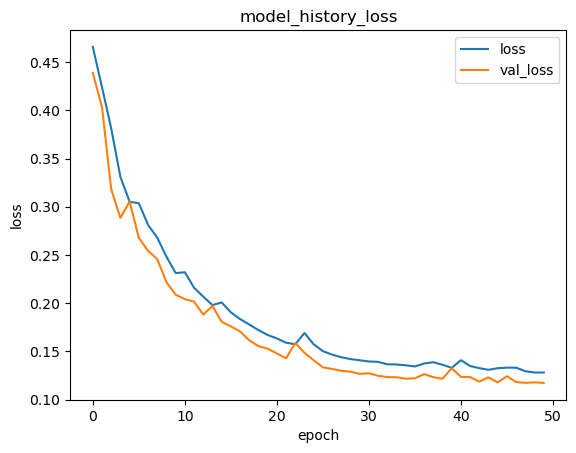

In [137]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_history_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['loss','val_loss'],loc='upper right')
plt.show()

In [15]:
### SAVING MODEL

In [138]:
autoencoder.save('/home/pratyush-g/Documents/Defect_Detection_Autoencoders/saved models/Magnetic_Tile_AutoEnc_SSIm_UpSampling2D/')

2023-08-09 14:30:59.842519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2023-08-09 14:30:59.854542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2023-08-09 14:30:59.865527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,?]
	 [[{{node inputs}}]]
2023-08-09

INFO:tensorflow:Assets written to: /home/pratyush-g/Documents/Defect_Detection_Autoencoders/saved models/Magnetic_Tile_AutoEnc_SSIm_UpSampling2D/assets


INFO:tensorflow:Assets written to: /home/pratyush-g/Documents/Defect_Detection_Autoencoders/saved models/Magnetic_Tile_AutoEnc_SSIm_UpSampling2D/assets


In [17]:
### LOADING MODEL

In [4]:
autoencoder = keras.models.load_model('/home/pratyush-g/Documents/Defect_Detection_Autoencoders/saved models/Magnetic_Tile_AutoEnc_SSIm+MSE/',custom_objects ={'ssim_loss':ssim_loss, 'mse_loss':mse_loss})

2023-08-14 15:11:06.272310: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [ ]:
### SSIM CALCULATION FUNCTION

: 

: 

: 

In [7]:

def cal_ssim(img1, img2):
    
    K = [0.01, 0.03]
    L = 255
    kernelX = cv2.getGaussianKernel(11, 1.5)
    window = kernelX * kernelX.T
     
    M,N = np.shape(img1)

    C1 = (K[0]*L)**2
    C2 = (K[1]*L)**2
    img1 = np.float64(img1)
    img2 = np.float64(img2)
 
    mu1 = signal.convolve2d(img1, window, 'valid')
    mu2 = signal.convolve2d(img2, window, 'valid')
    
    mu1_sq = mu1*mu1
    mu2_sq = mu2*mu2
    mu1_mu2 = mu1*mu2
    
    
    sigma1_sq = signal.convolve2d(img1*img1, window, 'valid') - mu1_sq
    sigma2_sq = signal.convolve2d(img2*img2, window, 'valid') - mu2_sq
    sigma12 = signal.convolve2d(img1*img2, window, 'valid') - mu1_mu2
   
    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))
    mssim = np.mean(ssim_map)
    return mssim,ssim_map


In [ ]:
###  DEFECT SEGMENTATION AND MASK FUNCTION

: 

: 

: 

In [8]:
def ssim_seg(ori_img, re_img):
   
    # convert the images to grayscale
    if len(ori_img.shape) == 3:
        ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2GRAY)
    if len(re_img.shape) == 3:
        re_img = cv2.cvtColor(re_img, cv2.COLOR_BGR2GRAY)
    (s, s_map) = cal_ssim(ori_img, re_img)
    #(s, s_map) = structural_similarity(ori_img, re_img, full=True,multichannel=True)
    s      = np.clip(s_map, 0, 1)
    return s_map

def seg_mask(s_map, threshold=125):
    s_map = (s_map * 255).astype("uint8")
    mask = s_map.copy()
    mask[s_map > threshold] = 255
    mask[s_map <= threshold] = 0
    return mask

In [ ]:
# def mse(imageA, imageB):
# 	# the 'Mean Squared Error' between the two images is the
# 	# sum of the squared difference between the two images;
# 	# NOTE: the two images must have the same dimension
# 	err = np.sum((imageA - imageB) ** 2)
# 	#err /= float(imageA.shape[0] * imageA.shape[1])
	
# 	# return the MSE, the lower the error, the more "similar"
# 	# the two images are
# 	return err

: 

: 

: 

In [ ]:
### CHECKING FOR DEFECT FOR A SINGLE IMAGE FILE

: 

: 

: 

1/1 [==============================] - 0s 192ms/step
ssim value is : 0.43423558269010337
/home/pratyush-g/Pictures/Nick.png is Defected
Inference time is 0.6608103660000779 seconds


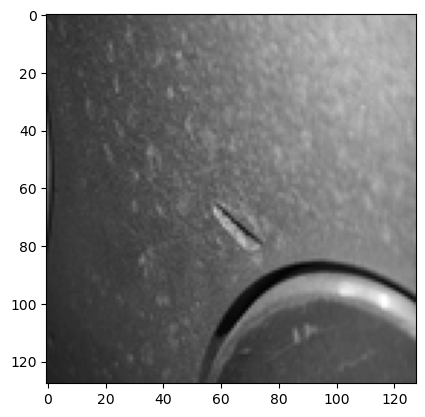

In [11]:
import numpy as np
import time
start = time.process_time()

width = 128
height = 128

file_name = r'/home/pratyush-g/Pictures/Nick.png'
img = Image.open(file_name)
# img = img.convert("RGB")
img = img.convert("L") # gray scale
img = img.resize((width,height), 1)
data = np.array(img)

plt.imshow(img)
plt.gray()

data = data.astype('float32') / 255.
test_img = np.reshape(data, (1,128, 128, 1))  # adapt this if using `channels_first` image data format
#print (test_img.shape)
decoded_imgs = autoencoder.predict(test_img)
npDecoded = decoded_imgs.reshape((128,128))
formatted2 = (npDecoded * 255 / np.max(npDecoded)).astype('uint8')
decoded = Image.fromarray(formatted2)
npImg = data
npImg = npImg.reshape((128,128))
img = Image.fromarray(npImg)
#err = mse(img, formatted2)
#print(err)
#value,dd = cal_ssim(img,decoded)    
value,dd = structural_similarity(npImg, npDecoded, data_range=npImg.max() - npDecoded.min(), full=True)  
if value<0.86:
    ok = 'Defected'
else:
    ok = 'Not Defected'

print(f'ssim value is : {value}')
print(f'{file_name} is {ok}')
end = time.process_time() 
# your code here    
print(f"Inference time is {end-start} seconds")

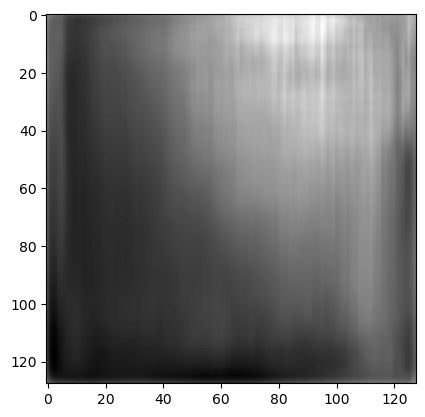

In [12]:
#plotting decoded image
plt.imshow(decoded_imgs.reshape(128, 128))
plt.gray()

[[  0   0 255   0 255   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0 255   0 255   0   0   0
    0   0   0   0 255   0   0   0   0   0   0   0   0   0   0 255   0   0
    0   0]
 [  0 255   0   0 255   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0 255   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0 255   0   0   0
    0   0   0   0 255   0  

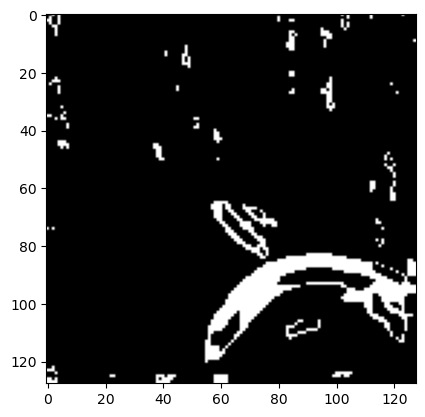

In [13]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

# plotting residual map 
(score, diff) = structural_similarity(npImg, npDecoded, data_range=npImg.max() - npDecoded.min(), full=True)
diff = (diff * 255).astype("uint8")
s_map = ssim_seg(npImg, npDecoded)
mask= seg_mask(diff, threshold = 230)
print(mask)
plt.imshow(mask)
plt.gray()

In [14]:
h,w = mask.shape
print(mask.shape)

def cc(img):
  
  r = np.zeros((h,w))
  k = 1
  for i in range(1,h):

    for j in range(1,w):

      if img[i,j] == 255:

        if ((img[i,j-1] == 0) and (img[i-1,j] == 0)):
          r[i,j] = k
          k += 1

        elif ((img[i,j-1] == 255) and (img[i-1,j] == 0)):
          r[i,j] = r[i,j-1]
        
        elif ((img[i,j-1] == 0) and (img[i-1,j] == 255)):
          r[i,j] = r[i-1,j]

        elif ((img[i,j-1] == 255) and (img[i-1,j] == 255)):
          r[i,j] = r[i-1,j]
          if r[i,j-1]!=r[i-1,j]:
            r[i,j-1] = r[i-1,j]

  return r

(128, 128)


[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  14.
  15.  17.  18.  19.  20.  22.  24.  25.  26.  27.  28.  30.  31.  32.
  33.  34.  35.  36.  37.  38.  40.  41.  42.  43.  44.  45.  46.  47.
  48.  49.  50.  51.  52.  53.  54.  56.  57.  58.  59.  60.  61.  62.
  63.  65.  66.  67.  68.  69.  70.  71.  73.  74.  75.  77.  79.  80.
  81.  84.  90.  91. 102. 103. 104. 106. 107. 109. 110. 112. 113. 115.
 117. 118. 119. 120. 121. 122. 123. 124. 125. 126. 128.] [15223     4     2     2     3     2     5    10     1    15     1     3
     1     8     2     5     4     4    17     1     1     3     2     3
     4     1     4     1     1     3     1     2     2     3     9     9
    13     1     2     1     1     1     1     3     2     7     2     8
   103    14     1    16     3     1     1     1     2     1   235   211
    81    17    63     1     1    12     1     1     1     7    74    15
    21     5     2     3     1    10     4     3     2     4     1     1
     1

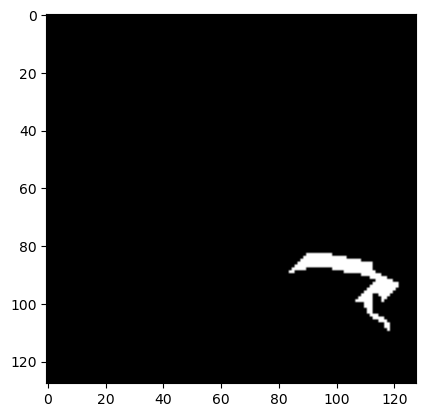

In [15]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

a, b = mask.shape
r = cc(mask)
#print(r)
elemnets,freq=np.unique(r,return_counts=True)
print(elemnets, freq)
# #x = freq.sort()
# #x = x[-3:-2]
# #print(x)
# # elements = elemnets[x[1]]
# # pri1nt(elements)
# #x = numpy.amax(r, axis=None)
# freq = sorted(freq)
# print(freq)
# #freq = freq[-3:0]
# print(elemnets[freq := freq[-2]])

from collections import Counter

ctr = Counter(r.ravel())
second_most_common_value, its_frequency = ctr.most_common(2)[1]

print(second_most_common_value)

for i in range(a):
    for j in range(b):
        if r[i,j] == second_most_common_value:
            r[i][j] = 255
        else:
            r[i][j] = 0

plt.imshow(r)
plt.gray()

Text(0.5, 1.0, 'SSIM_Map')

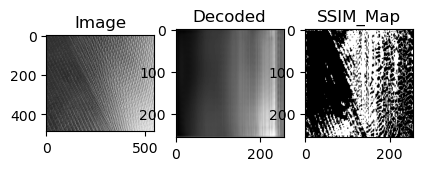

In [17]:
x = r'/home/pratyush-g/Pictures/FishScale.png'
img = Image.open(x)

plt.subplot(1,4,1)
plt.imshow(img, cmap='gray')
plt.title('Image')
plt.subplot(1,4,2)
plt.imshow(decoded, cmap = 'gray')
plt.title('Decoded')
plt.subplot(1,4,3)
plt.imshow(mask, cmap='gray')
plt.title('SSIM_Map')
# plt.subplot(1,4,4)
# plt.imshow(r, cmap = 'gray')
# plt.title('Defect')

Number of Contours found = 366


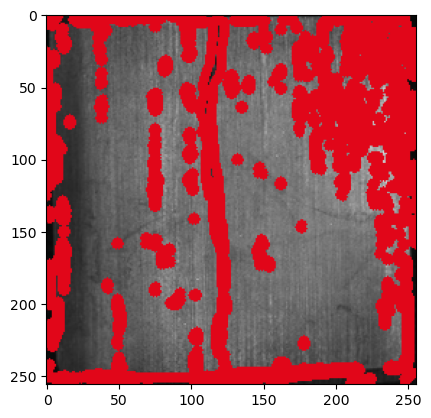

In [213]:
#-----------------------------
# Find Canny edges
edged = cv2.Canny(mask, 30, 200)
e = edged.copy()
# Finding Contours  Use a copy of the image e.g. edged.copy() since findContours alters the image
contours, hierarchy = cv2.findContours(e,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
print("Number of Contours found = " + str(len(contours)))
# Draw all contours (-1 signifies drawing all contours)
np=cv2.cvtColor(npImg,cv2.COLOR_GRAY2RGB)
img_=cv2.cvtColor(np,cv2.COLOR_RGB2HSV)
cv2.drawContours(img_, contours, -1, (1,200,287), 6)
im=cv2.cvtColor(img_,cv2.COLOR_HSV2RGB)
im = (im * 255).astype("uint8")
plt.imshow(im)
#-----------------------------
#plotting segmented defect on original image

In [ ]:
### CHECKING FOR DEFECT FOR A FOLDER CONTAINING TEST IMAGES

: 

: 

: 

(32, 256, 256, 1)
1/1 [==============================] - 1s 1s/step


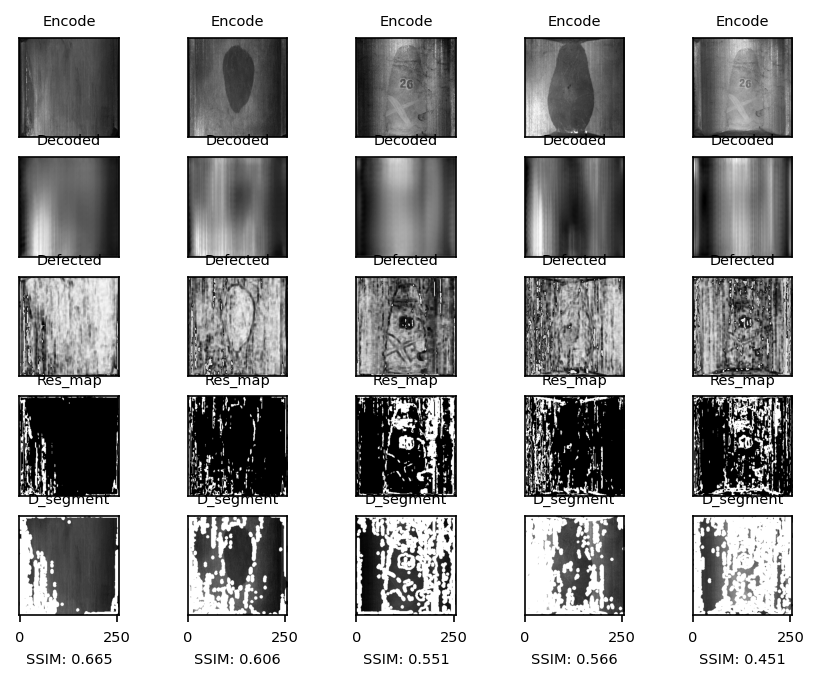

In [147]:
import numpy as np

s_values=[]

img_dir = (r"/home/pratyush-g/Documents/Surface Defect Dataset Chmvae/Magnetic-Tile-Defect/MT_Fray/Imgs/")
img_files = glob.glob(img_dir + "*.jpg")
# Setting Image Properties
width = 256
height = 256
 
# Load Image
x = []

for i, f in enumerate(img_files):
    img = Image.open(f)
    #img = img.convert("RGB")
    img = img.convert("L") # gray sclae
    img = img.resize((width,height), 1)
    data = np.asarray(img)
    x.append(data)

x_test = np.array(x)
x_test = x_test.astype('float32') / 255.
x_test = np.reshape(x_test, (len(x_test), 256, 256, 1))  # adapt this if using `channels_first` image data format
print (x_test.shape) 

decoded_imgs = autoencoder.predict(x_test)

defected = 0
non_defected = 0

n = 5  # number of images to be displayed
plt.figure(figsize=(7, 5), dpi=150)
for i in range(n):
    # display original
    ax = plt.subplot(5, n, i + 1)
    plt.imshow(x_test[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # SSIM Encode
    ax.set_title("Encode",fontsize=7)    
    npImg = x_test[i]
    npImg = npImg.reshape((256,256))
    formatted = (npImg * 255 / np.max(npImg)).astype('uint8')
    img = Image.fromarray(formatted)

    # display reconstruction
    ax = plt.subplot(5, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(256, 256))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # SSIM Decoded    
    npDecoded = decoded_imgs[i]
    npDecoded = npDecoded.reshape((256,256))
    formatted2 = (npDecoded * 255 / np.max(npDecoded)).astype('uint8')
    decoded = Image.fromarray(formatted2)
    
    value,dd = cal_ssim(img,decoded)
    s_values.append(value)
    
    if value<0.86:
        ok = 'Defected'
        defected+=1
            
    else:
        ok = 'Not Defected'
        non_defected+=1

    label = 'SSIM: {:.3f}'
    ax.set_title("Decoded",fontsize=7)
    (score, diff) = structural_similarity(npImg, npDecoded, data_range=npImg.max() - npDecoded.min(), full=True)
    diff = (diff * 255).astype("uint8")
    ax = plt.subplot(5, n, i + 1 + 2*n)
    
    plt.imshow(diff)
    plt.gray()
    ax.set_title(ok,fontsize=7)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    s_map = ssim_seg(npImg, npDecoded)
    mask= seg_mask(diff, threshold = 180)
    ax = plt.subplot(5, n, i + 1 + 3*n)
    plt.imshow(mask)
    plt.gray()
    ax.set_title("Res_map",fontsize=7)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_xlabel(label.format(value))
    
    # Find Canny edges
    edged = cv2.Canny(mask, 30, 200)
    e = edged.copy() 
    contours, hierarchy = cv2.findContours(e,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    ax = plt.subplot(5, n, i + 1 + 4*n)
    cv2.drawContours(npImg, contours, -1, (1,255,0), 6)
    plt.imshow(npImg)
    #plt.gray()    
    ax.set_title("D_segment",fontsize=7)
    ax.get_xaxis().set_visible(True)
    plt.xticks(fontsize=7)
    ax.get_yaxis().set_visible(False)
    ax.set_xlabel(label.format(value),fontsize=7)
    
    
plt.show()

In [30]:
print("Total number of images",n)
print("Defected images",defected)
print("Not defected images",non_defected)

Total number of images 5
Defected images 5
Not defected images 0


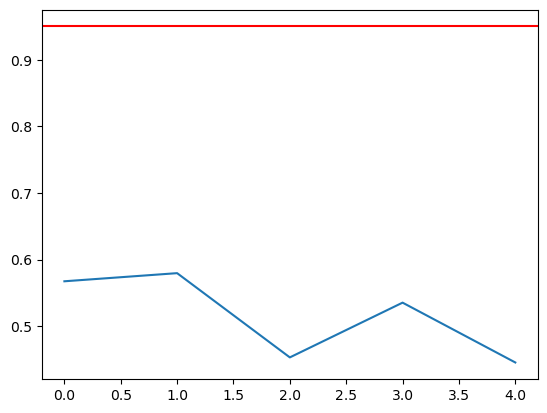

: 

: 

: 

In [ ]:
#plotting ssim values of test images with threshold red line 
plt.plot(s_values)
plt.axhline(y=0.95,color='r',linestyle='-')

: 

: 

: 